# 📌 Machine Learning Lab — Feature Selection   
### PCA vs SelectKBest (Mutual Information) with a simple baseline model

This lab is designed to be **easy to run in class** and **easy to teach from the notebook**.

✅ **What we focus on:** *feature reduction / selection strategies*  

---

## 🎯 Objectives
By the end of this lab, you will be able to:

- ✅ Load and inspect a tabular dataset  
- ✅ Train a baseline classifier  
- ✅ Apply **PCA** (unsupervised dimensionality reduction)  
- ✅ Apply **SelectKBest + Mutual Information** (supervised feature selection)  
- ✅ Compare solutions using **macro F1-score**  
- ✅ Visualize results with a clean **normalized confusion matrix**  

---

## 💡 Why feature selection?
Real datasets often contain redundant, noisy, or weak features. Reducing/selecting features can:

- 🔧 reduce training time and memory usage  
- 🧠 simplify models and interpretation  
- 🛡️ reduce overfitting (sometimes)  
- 📈 sometimes improve generalization (but not guaranteed)

---

## 🎯 Metric used: macro F1-score
- Computes an F1-score **per class**
- Then averages them **equally**  
➡️ Useful when classes are **imbalanced**


## 1) 🧰 Imports and setup

We keep the lab lightweight:

- **One main classifier:** Random Forest  
- **One main metric:** macro F1  
- **Fixed seed:** reproducibility  
- **Class imbalance handling:** `class_weight="balanced"` (important for this dataset)


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, classification_report, ConfusionMatrixDisplay, accuracy_score
)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 2) 📥 Load the labeled training data

✅ This lab requires a dataset containing a **target column** (labels).  
If the file has no target, it is an **unlabeled** test set and cannot be used for training.

**Dataset used (as provided/reviewed):** `data_reduced.csv`
- Some classes were removed because they were never predicted in the baseline setting.


In [2]:
# DATA_PATH = "data.csv"         # optional alternative
DATA_PATH = "data_reduced.csv"   # ✅ default reviewed dataset

df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()  # safety: remove extra spaces

print("Shape:", df.shape)
display(df.head())


Shape: (146505, 77)


,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
0,184152,0,0,0,4,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,Class_6
1,197541,0,0,10,35,2,0,0,1,10,...,0,4,1,0,26,0,0,0,0,Class_6
2,152477,3,0,4,20,0,7,0,1,1,...,0,1,8,0,4,1,0,2,0,Class_8
3,165474,0,2,1,1,1,0,0,0,5,...,4,0,3,0,0,0,1,0,0,Class_8
4,123755,0,4,2,4,0,2,1,0,0,...,0,0,0,0,0,1,0,0,0,Class_7


### 📊 Target distribution (class imbalance)

A strongly imbalanced dataset can cause a classifier to **favor majority classes**.

✅ We will address this by enabling **weight balancing** in the classifier:
- `class_weight="balanced"`

This tells the model to give more importance to minority classes during training.


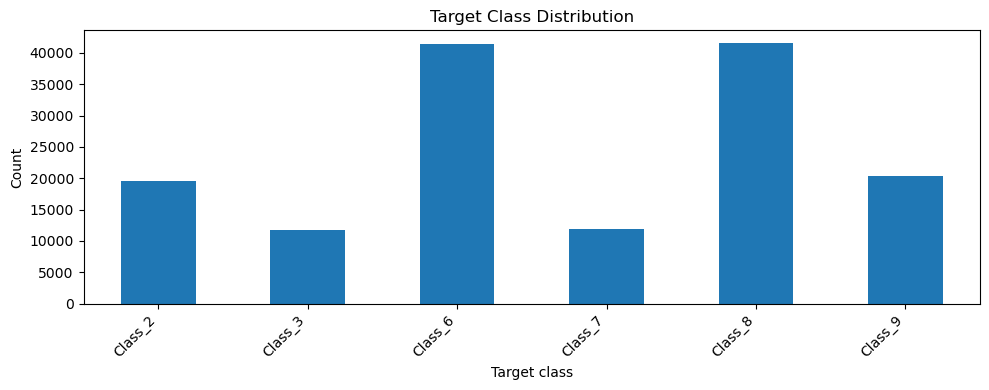

Number of classes: 6


In [3]:
target = "target"
counts = df[target].value_counts().sort_index()

plt.figure(figsize=(10, 4))
counts.plot(kind="bar")

plt.title("Target Class Distribution")
plt.xlabel("Target class")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("Number of classes:", df[target].nunique())


## 3) 🧹 Prepare features `X` and labels `y`

**Definitions**
- **Features (X):** input variables used for prediction  
- **Target (y):** the label we want to predict  

We drop `id` because it is typically an identifier (not useful for learning patterns).


In [4]:
X = df.drop(columns=["id", target], errors="ignore")
y = df[target]

print("X shape:", X.shape)
print("Number of classes:", y.nunique())


X shape: (146505, 75)
Number of classes: 6


## 4) ✂️ Train/test split (fast)

To keep the lab fast during class, we train on only **2000 rows**.

- `stratify=y` keeps class proportions similar in train and test.
- The remaining rows become the test set.

> **Teaching note:** This is a speed-friendly setup.  
> In real work, you would typically do **cross-validation** and tune hyperparameters.


In [5]:
TRAIN_ROWS = 2000

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=TRAIN_ROWS,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (2000, 75)  Test: (144505, 75)


## 5) 🤖 Baseline model (Full features)

We train a **Random Forest** on the original feature set.

**Why Random Forest?**
- ✅ strong default for tabular data  
- ✅ handles nonlinear patterns  
- ✅ minimal preprocessing needed  
- ✅ supports class weighting for imbalance  

We also define a small helper function to keep evaluation consistent.


✅ Full features macro-F1: 0.245


## 6) 🧠 PCA (unsupervised dimensionality reduction)

**PCA (Principal Component Analysis)** creates new features (**components**) as linear combinations of the original ones.

Key points:
- 🧠 PCA does **not** use the target → **unsupervised**
- 📏 PCA is variance-based → we **scale** features first
- 🛡️ Fit PCA on **training only** (avoid data leakage)
- 🎯 Keep enough components to explain about **80%** of variance


✅ PCA kept 51 components (≈ 80.2% variance)


In [9]:
rf_pca = RandomForestClassifier(**rf_params)

pred_pca, f1_pca = fit_predict_score(rf_pca, X_train_pca, y_train, X_test_pca, y_test)
print("✅ PCA macro-F1:", round(f1_pca, 3))


✅ PCA macro-F1: 0.221


## 7) 🎯 SelectKBest (supervised feature selection)

**SelectKBest** keeps the top-`k` original features using a scoring function.

We use **mutual information**:
- measures dependency between each feature and the target  
- can capture nonlinear relationships  
- **supervised** (uses the target)

✅ For a fair comparison with PCA, we set:

- `k = number of PCA components`  
- i.e., `k = k_pca`


✅ SelectKBest kept k = 51 features


In [12]:
rf_k = RandomForestClassifier(**rf_params)

pred_k, f1_k = fit_predict_score(rf_k, X_train_k, y_train, X_test_k, y_test)
print("✅ SelectKBest macro-F1:", round(f1_k, 3))


✅ SelectKBest macro-F1: 0.243


## 8) 📊 Compare feature strategies

We compare the three approaches using **the same metric** (macro F1).

Teaching points:
- Feature reduction can help… or hurt.
- If performance drops, it may mean we removed useful information.
- If performance improves, reduction may have removed noise or redundancy.


,Approach,macro_F1
0,Full,0.244546
2,SelectKBest (Mutual Info),0.242851
1,PCA (80% variance),0.221099


🏆 Best approach: Full


## 9) 🧾 Best approach: report + confusion matrix

We display:
- 📄 classification report (precision/recall/F1 per class)
- 🧩 normalized confusion matrix (each row sums to 1)

> **Tip for teaching:** ask students to identify which classes are most confused and why imbalance may matter.


📌 Best solution: Full
              precision    recall  f1-score   support

     Class_2       0.31      0.37      0.34     19280
     Class_3       0.16      0.15      0.15     11630
     Class_6       0.40      0.48      0.44     40888
     Class_7       0.09      0.02      0.03     11682
     Class_8       0.36      0.44      0.40     40957
     Class_9       0.17      0.08      0.11     20068

    accuracy                           0.34    144505
   macro avg       0.25      0.26      0.24    144505
weighted avg       0.30      0.34      0.31    144505



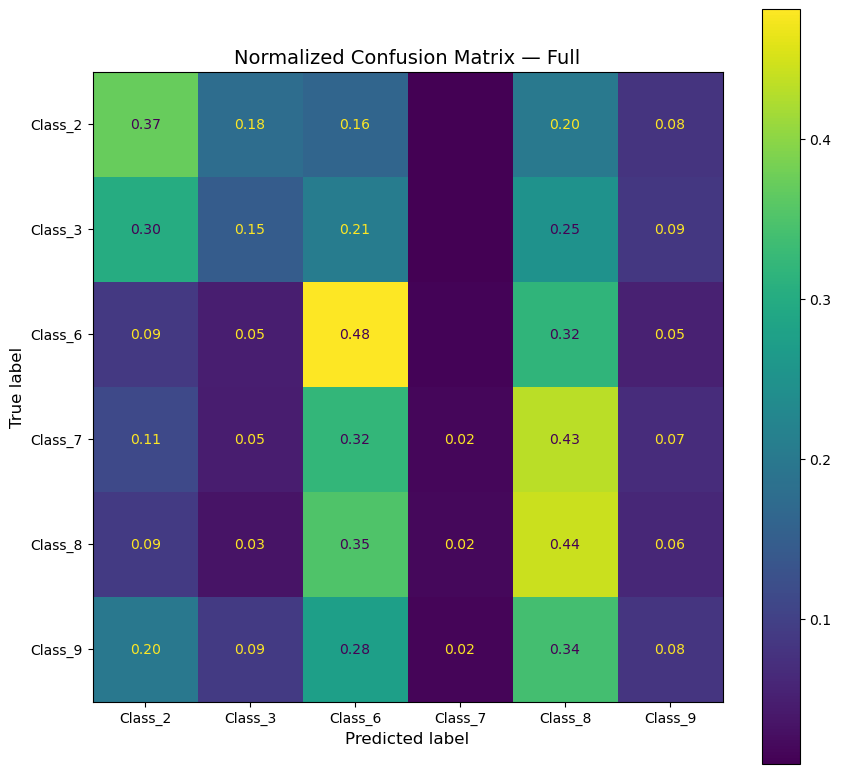

In [14]:
best_preds = pred_full
best_model = rf_full
X_best_train = X_train
label = "Full"

if best_name.startswith("PCA"):
    best_preds = pred_pca
    best_model = rf_pca
    X_best_train = X_train_pca
    label = "PCA"
elif best_name.startswith("SelectKBest"):
    best_preds = pred_k
    best_model = rf_k
    X_best_train = X_train_k
    label = "SelectKBest"

print(f"📌 Best solution: {label}")
print(classification_report(y_test, best_preds, zero_division=0))

fig, ax = plt.subplots(figsize=(9, 8))
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, best_preds,
    normalize="true",
    ax=ax,
    values_format=".2f"
)

# Hide tiny values for readability
for text in disp.text_.ravel():
    try:
        val = float(text.get_text())
        text.set_text(f"{val:.2f}" if val > 0.01 else "")
    except Exception:
        pass

ax.set_title(f"Normalized Confusion Matrix — {label}", fontsize=14)
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)
plt.tight_layout()
plt.show()


## 10) 🔍 Overfitting check (train vs test accuracy)

Overfitting often shows:
- very high training accuracy
- much lower test accuracy

We compare train vs test accuracy for the selected best approach.

✅ **Exercise for students:** reduce overfitting by optimizing hyperparameters (depth, number of trees, min samples per leaf, etc.).


In [16]:
train_preds = best_model.predict(X_best_train)
train_acc = accuracy_score(y_train, train_preds)
test_acc  = accuracy_score(y_test, best_preds)

print(f"Train accuracy: {train_acc:.3f}")
print(f"Test  accuracy: {test_acc:.3f}")

if train_acc - test_acc > 0.10:
    print("🔍 Likely overfitting. Try tuning hyperparameters as an exercise.")


Train accuracy: 0.924
Test  accuracy: 0.336
🔍 Likely overfitting. Try tuning hyperparameters as an exercise.


## 11) 🔎 Optional extension — Model comparison on PCA features

So far, we kept the model fixed (**Random Forest**) to isolate the effect of feature selection.

Here we briefly compare:
- Logistic Regression (linear baseline)
- Random Forest (nonlinear model)

on the **same PCA features**.


,Model,macro_F1
1,Random Forest,0.221099
0,Logistic Regression,0.211526


## 12) 🧠 Interpretation of the results (teaching notes)

- This dataset is **difficult** and **imbalanced**.
- The goal is to learn the **workflow** of feature selection/reduction.
- The performance is **not expected to be great** without fine tuning.

### Why PCA may perform worse
- PCA keeps directions of **high variance**, not necessarily directions that best separate classes.

### Why SelectKBest can be close to full features
- Mutual information is **supervised**, so it tends to retain features that matter for the target.

### Key takeaway
Feature selection is a **tool**, not a guarantee:
- sometimes it improves performance,
- sometimes it removes useful signal and hurts performance.


## 13) 🧪 Optional: apply the best approach to a separate test file

⚠️ Two possibilities:

- If `data_test.csv` contains `target`, we can evaluate it.
- If it does not contain `target`, we only generate predictions.

> Teaching simplification: we reuse the training subset.  
> In real applications, retrain on all labeled data before final prediction.


Test shape: (40000, 77)
              precision    recall  f1-score   support

     Class_1       0.00      0.00      0.00      1873
     Class_2       0.27      0.37      0.31      4884
     Class_3       0.14      0.14      0.14      3007
     Class_4       0.00      0.00      0.00       893
     Class_5       0.00      0.00      0.00       625
     Class_6       0.37      0.47      0.42     10357
     Class_7       0.08      0.02      0.03      2926
     Class_8       0.33      0.44      0.38     10239
     Class_9       0.15      0.07      0.10      5196

    accuracy                           0.30     40000
   macro avg       0.15      0.17      0.15     40000
weighted avg       0.25      0.30      0.27     40000



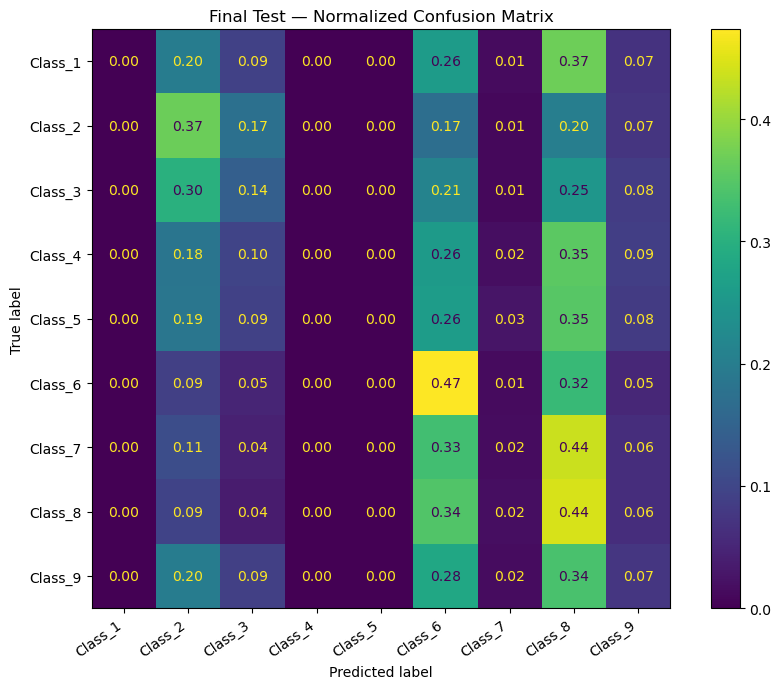

In [22]:
TEST_PATH = "data_test_prof.csv"

try:
    df_test = pd.read_csv(TEST_PATH)
    print("Test shape:", df_test.shape)

    X_final = df_test.drop(columns=[c for c in ["id", "target"] if c in df_test], errors="ignore")

    if label == "PCA":
        best_model.fit(X_train_pca, y_train)
        X_final = pca.transform(scaler.transform(X_final))
    elif label == "SelectKBest":
        best_model.fit(X_train_k, y_train)
        X_final = selector.transform(X_final)
    else:  # Full
        best_model.fit(X_train, y_train)

    pred = best_model.predict(X_final)

    if "target" in df_test:
        y_true = df_test["target"]
        print(classification_report(y_true, pred, zero_division=0))

        fig, ax = plt.subplots(figsize=(9, 7))
        ConfusionMatrixDisplay.from_predictions(
            y_true, pred, normalize="true", values_format=".2f", ax=ax
        )
        ax.set_title("Final Test — Normalized Confusion Matrix")
        plt.xticks(rotation=35, ha="right")
        plt.tight_layout()
        plt.show()

    else:
        display(pd.DataFrame({"id": df_test["id"], "target": pred}).head())

except FileNotFoundError:
    print("Test file not found:", TEST_PATH)


## ✅ Outcomes

After completing this notebook, you should have:

- 📌 Baseline performance on full features (macro F1)
- 🧠 PCA reduced-feature performance (macro F1)
- 🎯 SelectKBest selected-feature performance (macro F1)
- 📊 A comparison table identifying the best feature strategy
- 🧾 A classification report + normalized confusion matrix for the best approach
- 🔍 A train vs test accuracy check (overfitting sanity check)
- 🔎 (Optional) A brief model comparison on PCA features
- 🧪 (Optional) Predictions/evaluation on a separate test file

### One-sentence takeaway
**PCA compresses features without labels; SelectKBest keeps original features that are most informative about the labels.**
